In [1]:
import os
import sys

root_dir = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
model_dir = os.path.join(root_dir, "model")
sys.path.append(root_dir)
sys.path.append(model_dir)

import time
import json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hoho_utils
import hoho_config


plt.style.use('ggplot')

In [2]:
def suffix_time():
    current_time = time.time()
    local_time = time.localtime(current_time)
    time_str = time.strftime('%Y%m%d%H%M%S', local_time)
    return time_str

In [3]:
suffix = suffix_time()
suffix

'20230925174927'

### 加载走子数据

In [4]:
data_dir = "../output/data"
file_list = os.listdir(data_dir)
file_count = len(file_list)

expect_file_list = []
for i, filename in enumerate(file_list):
    if not filename.startswith(hoho_config.REPLAY_BUFFER_FILE_PREFIX):
        continue
    expect_file_list.append(filename)

item_list = list()
print(f"file_count: {len(expect_file_list)}")

for i, filename in enumerate(expect_file_list):
    if not filename.startswith(hoho_config.REPLAY_BUFFER_FILE_PREFIX):
        continue
        
    file_path = os.path.join(data_dir, filename)
    print(file_path)
    with open(file_path, "r") as file:
        json_str = file.read()
        matches = json.loads(json_str)
        match_count = len(matches)

        for j, match in enumerate(matches):
            base_id =  int(time.time() * 1000) + j
            for k, round in enumerate(match):
                match_id = f"{i}-{j}"
                round_id = f"{base_id}-{k}"
                state = round[0]
                action = round[2]
                next_state = round[3]
                raw_reward = round[4]
                done = round[5]
                chapture_list = round[6]
                chaptures = ','.join(chapture_list)
                chapture_reward = round[7]
                re_reward = round[8]

                round_dict = {"match_id": match_id,
                              "round_id": round_id,
                              "state": state,
                              "action":action,
                              "next_state": next_state,
                              "done": done,
                              "chaptures": chaptures,
                              "chapture_reward": chapture_reward,
                              "raw_reward": raw_reward,
                              "re_reward": re_reward}
                item_list.append(round_dict)

                if done:
                    break

file_count: 37
../output/data\DoubleDQNAb_1695306577_46.json
../output/data\DoubleDQNAb_1695312498_136.json
../output/data\DoubleDQNAb_1695323429_275.json
../output/data\DoubleDQNAb_1695329812_372.json
../output/data\DoubleDQNAb_1695335189_453.json
../output/data\DoubleDQNAb_1695340489_533.json
../output/data\DoubleDQNAb_1695350954_681.json
../output/data\DoubleDQNAb_1695357001_773.json
../output/data\DoubleDQNAb_1695363632_873.json
../output/data\DoubleDQNAb_1695371445_993.json
../output/data\DoubleDQNAb_1695379037_1108.json
../output/data\DoubleDQNAb_1695387229_1233.json
../output/data\DoubleDQNAb_1695394715_1346.json
../output/data\DoubleDQNAb_1695403127_1473.json
../output/data\DoubleDQNAb_1695411535_1599.json
../output/data\DoubleDQNAb_1695420475_1732.json
../output/data\DoubleDQNAb_1695429441_1866.json
../output/data\DoubleDQNAb_1695439457_2016.json
../output/data\DoubleDQNAb_1695448186_2142.json
../output/data\DoubleDQNAb_1695459960_2301.json
../output/data\DoubleDQNAb_169546961

In [7]:
data = pd.DataFrame(item_list)

In [8]:
data

,match_id,round_id,state,action,next_state,done,chaptures,chapture_reward,raw_reward,re_reward
0,0-0,1695635369878-0,RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c...,h2e2,RNBAKABNR/9/1C2C4/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,False,,0.00,0,-82.9000
1,0-0,1695635369878-1,RNBAKABNR/9/1C2C4/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,e2h2,RNBAKABNR/9/1C5C1/P1P1c1P1P/9/9/p1p1p1p1p/1c7/...,False,P,-1.00,0,-91.9000
2,0-0,1695635369878-2,RNBAKABNR/9/1C5C1/P1P1c1P1P/9/9/p1p1p1p1p/1c7/...,g0e2,RNBAcA1NR/9/1C2B2C1/P1P3P1P/9/9/p1p1p1p1p/1c7/...,True,K,-100.00,-1,-91.9000
3,0-1,1695635369879-0,RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c...,h2e2,RNBAKABNR/9/1C2C4/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,False,,0.00,0,-3.5200
4,0-1,1695635369879-1,RNBAKABNR/9/1C2C4/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,c3c4,RNBAKABNR/9/1C2C4/P3c1P1P/2P6/9/p1p1p1p1p/1c7/...,False,P,-1.00,0,-3.7000
...,...,...,...,...,...,...,...,...,...,...
19868,36-49,1695635379122-9,R2AKABNR/9/4B2r1/P3c1P1P/2P6/9/p1p1p1p1p/4c1n2...,e2c0,R1BAKABNR/9/7r1/P5P1c/2P6/9/p1p1p1p1p/4c1n2/9/...,False,P,-1.00,0,-5.3749
19869,36-49,1695635379122-10,R1BAKABNR/9/7r1/P5P1c/2P6/9/p1p1p1p1p/4c1n2/9/...,c0e2,R2AKABNR/9/4B2r1/P5Pc1/2P6/9/p1p1p1p1p/4c1n2/9...,False,,0.00,0,-7.3810
19870,36-49,1695635379122-11,R2AKABNR/9/4B2r1/P5Pc1/2P6/9/p1p1p1p1p/4c1n2/9...,i0i5,R2AKABN1/9/4B2r1/P5Pc1/2P6/8p/p1p1p1p2/4c1n2/9...,False,R,-4.29,0,-88.4710
19871,36-49,1695635379122-12,R2AKABN1/9/4B2r1/P5Pc1/2P6/8p/p1p1p1p2/4c1n2/9...,h0g2,R2AKAB2/9/4B1r2/P5Pc1/2P6/8p/p1p1p1p2/4c1n2/9/...,False,N,-2.00,0,-96.6610


In [9]:
data.to_excel(f"./outputs/hoho_chess_data_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.xlsx", index = False)

### 看看随着模型不断学习升级，累积奖励的趋势

In [10]:
data_group = data.groupby(["match_id"], as_index = False).agg({"re_reward": sum, "chapture_reward": sum, "round_id": "count"})
data_group.rename(columns = {"round_id": "step_count"}, inplace = True)
data_group

,match_id,re_reward,chapture_reward,step_count
0,0-0,-266.7000,-101.00,3
1,0-1,-290.6979,-106.29,6
2,0-10,-269.5100,-101.00,5
3,0-11,-269.5100,-101.00,5
4,0-12,-266.7000,-101.00,3
...,...,...,...,...
1845,9-5,-337.9893,-115.45,15
1846,9-6,-316.6114,-110.16,13
1847,9-7,-291.7586,-104.87,11
1848,9-8,-278.3086,-102.87,7


In [11]:
data_group["match_id1"] = data_group["match_id"].apply(lambda x: x.split("-")[0]).astype(int)
data_group["match_id2"] = data_group["match_id"].apply(lambda x: x.split("-")[-1]).astype(int)
data_group

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2
0,0-0,-266.7000,-101.00,3,0,0
1,0-1,-290.6979,-106.29,6,0,1
2,0-10,-269.5100,-101.00,5,0,10
3,0-11,-269.5100,-101.00,5,0,11
4,0-12,-266.7000,-101.00,3,0,12
...,...,...,...,...,...,...
1845,9-5,-337.9893,-115.45,15,9,5
1846,9-6,-316.6114,-110.16,13,9,6
1847,9-7,-291.7586,-104.87,11,9,7
1848,9-8,-278.3086,-102.87,7,9,8


In [12]:
data_group_sorted = data_group.sort_values(by = "match_id1")
data_group_sorted

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2
0,0-0,-266.7000,-101.00,3,0,0
27,0-33,-185.6000,-102.00,2,0,33
28,0-34,-287.4328,-105.29,7,0,34
29,0-35,-298.4197,-105.58,13,0,35
30,0-36,-306.9251,-110.00,8,0,36
...,...,...,...,...,...,...
1520,36-27,-323.4684,-111.87,12,36,27
1521,36-28,-295.5449,-106.00,11,36,28
1522,36-29,-298.6156,-106.58,10,36,29
1511,36-19,-313.0815,-107.58,12,36,19


In [13]:
data_group_sorted2 = data_group_sorted.groupby("match_id1").apply(lambda x: x.sort_values(by = "match_id2"))
data_group_sorted3 = data_group_sorted2.reset_index(drop = True)

In [14]:
data_group_sorted3

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2
0,0-0,-266.7000,-101.00,3,0,0
1,0-1,-290.6979,-106.29,6,0,1
2,0-2,-318.8449,-112.00,10,0,2
3,0-3,-297.4256,-106.58,8,0,3
4,0-4,-266.7000,-101.00,3,0,4
...,...,...,...,...,...,...
1845,36-45,-294.1056,-105.58,9,36,45
1846,36-46,-294.6387,-104.29,12,36,46
1847,36-47,-282.6556,-103.58,7,36,47
1848,36-48,-304.9356,-107.58,12,36,48


In [15]:
data_group_sorted3.to_excel(f"./outputs/hoho_ddqn_total_rewards_data_by_match_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.xlsx", index = False)

In [16]:
def smooth_plot(val_list):
    result_list = []
    current_val = 0
    for i, val in enumerate(val_list):
        current_val = val * 0.05 + 0.95 * current_val
        result_list.append(current_val)
    return result_list

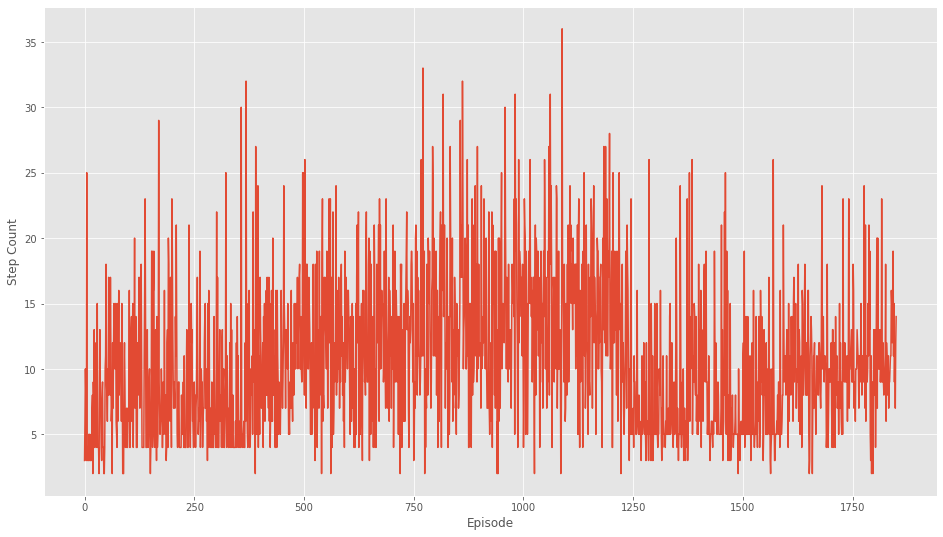

In [17]:
### 对战步数
plt.figure(figsize = (16, 9))
x = range(data_group_sorted3["step_count"].values.shape[0])
y = data_group_sorted3["step_count"].values
plt.xlabel("Episode")
plt.ylabel("Step Count")
plt.plot(x, y)
plt.savefig(f"./outputs/images/step_count_1_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

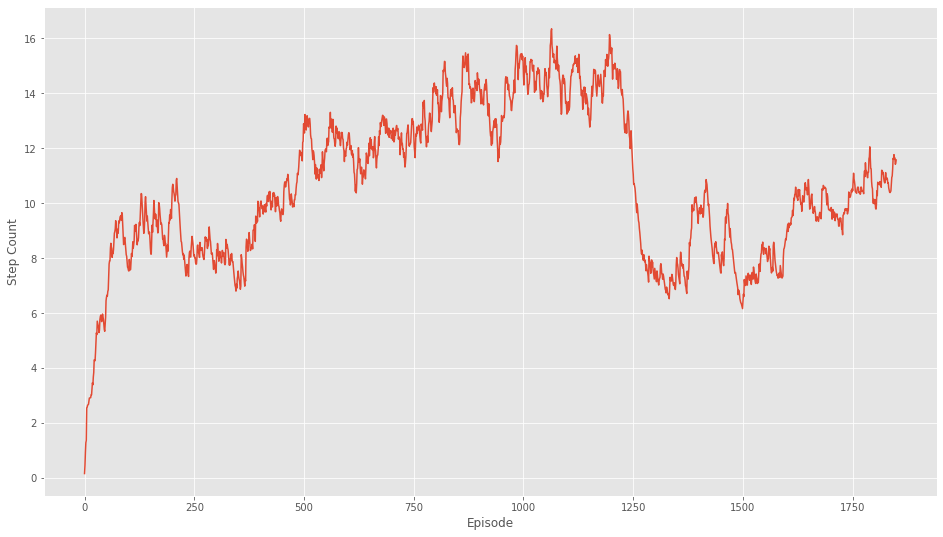

In [18]:
# 做一下平滑

y = smooth_plot(data_group_sorted3["step_count"].values)
x = range(len(y))
plt.figure(figsize = (16, 9))
plt.xlabel("Episode")
plt.ylabel("Step Count")
plt.plot(x, y)
plt.savefig(f"./outputs/images/step_count_2_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

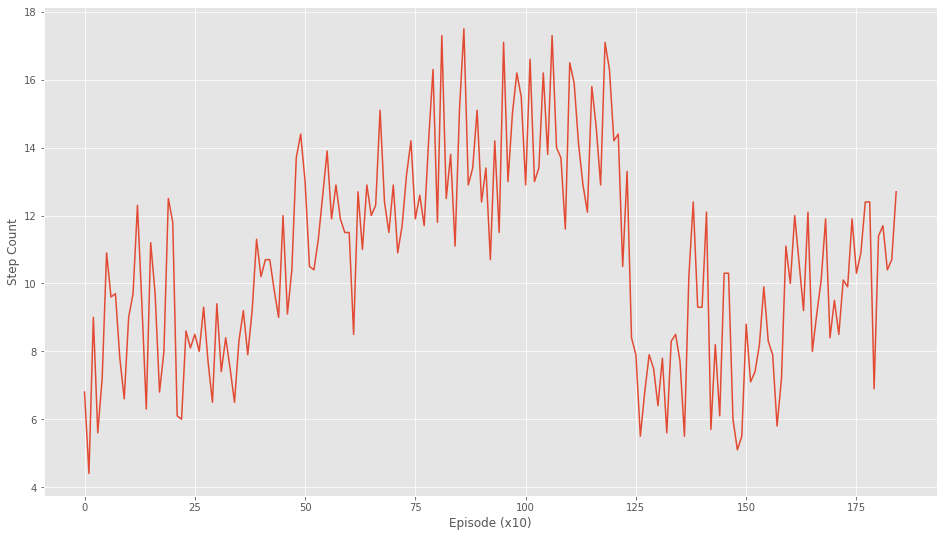

In [19]:
# 做一下平滑2
avg_step_counts = []
step_counts = data_group_sorted3["step_count"].values.tolist()
for i, val in enumerate(step_counts):
    if (i + 1) % 10 == 0:
        avg_val = np.mean(step_counts[(i + 1 - 10): (i + 1)])
        avg_step_counts.append(avg_val)

plt.figure(figsize = (16, 9))
plt.xlabel("Episode (x10)")
plt.ylabel("Step Count")
plt.plot(range(len(avg_step_counts)), avg_step_counts)
plt.savefig(f"./outputs/images/step_count_3_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

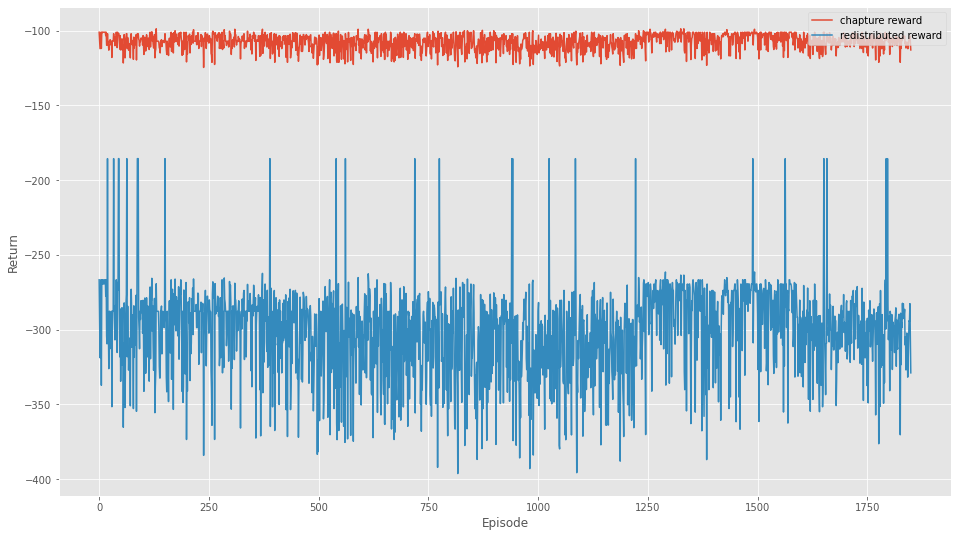

In [20]:
### 累积吃子奖励
plt.figure(figsize = (16, 9))
x = range(data_group_sorted3["chapture_reward"].values.shape[0])
y1 = data_group_sorted3["chapture_reward"].values
y2 = data_group_sorted3["re_reward"].values
plt.xlabel("Episode")
plt.ylabel("Return")
plt.plot(x, y1, label = "chapture reward")
plt.plot(x, y2, label = "redistributed reward")
plt.legend(loc = "upper right")
plt.savefig(f"./outputs/images/return_1_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

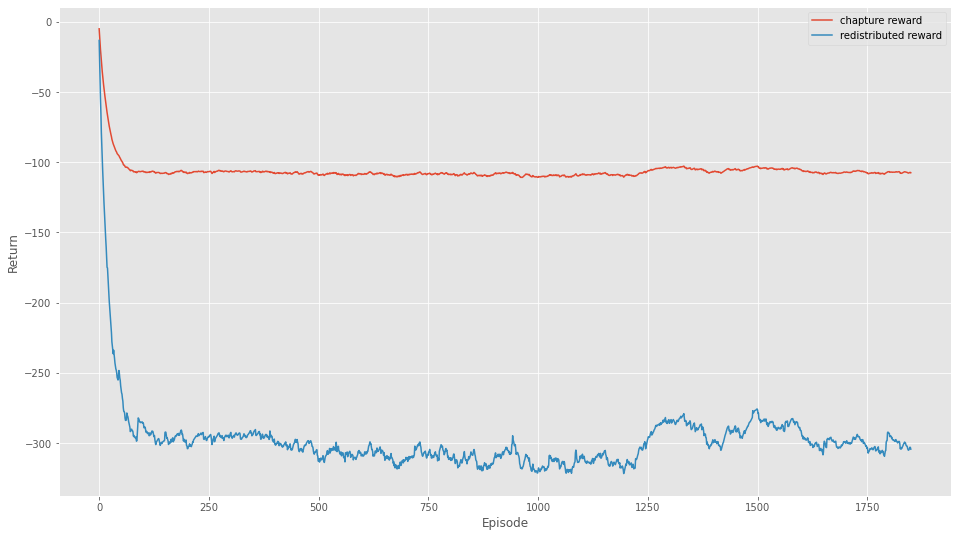

In [21]:
# 平滑处理
y1 = smooth_plot(data_group_sorted3["chapture_reward"].values)
y2 = smooth_plot(data_group_sorted3["re_reward"].values)
x = range(len(y1))
plt.figure(figsize = (16, 9))
plt.xlabel("Episode")
plt.ylabel("Return")
plt.plot(x, y1, label = "chapture reward")
plt.plot(x, y2, label = "redistributed reward")
plt.legend(loc = "upper right")
plt.savefig(f"./outputs/images/return_2_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

In [22]:
data_group_sorted3["avg_chapture_reward"] = data_group_sorted3["chapture_reward"] / data_group_sorted3["step_count"]
data_group_sorted3["avg_re_reward"] = data_group_sorted3["re_reward"] / data_group_sorted3["step_count"]
data_group_sorted3

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2,avg_chapture_reward,avg_re_reward
0,0-0,-266.7000,-101.00,3,0,0,-33.666667,-88.900000
1,0-1,-290.6979,-106.29,6,0,1,-17.715000,-48.449650
2,0-2,-318.8449,-112.00,10,0,2,-11.200000,-31.884490
3,0-3,-297.4256,-106.58,8,0,3,-13.322500,-37.178200
4,0-4,-266.7000,-101.00,3,0,4,-33.666667,-88.900000
...,...,...,...,...,...,...,...,...
1845,36-45,-294.1056,-105.58,9,36,45,-11.731111,-32.678400
1846,36-46,-294.6387,-104.29,12,36,46,-8.690833,-24.553225
1847,36-47,-282.6556,-103.58,7,36,47,-14.797143,-40.379371
1848,36-48,-304.9356,-107.58,12,36,48,-8.965000,-25.411300


In [23]:
data_group_sorted3.to_excel(f"./outputs/hoho_avg-chapture-reward_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.xlsx")

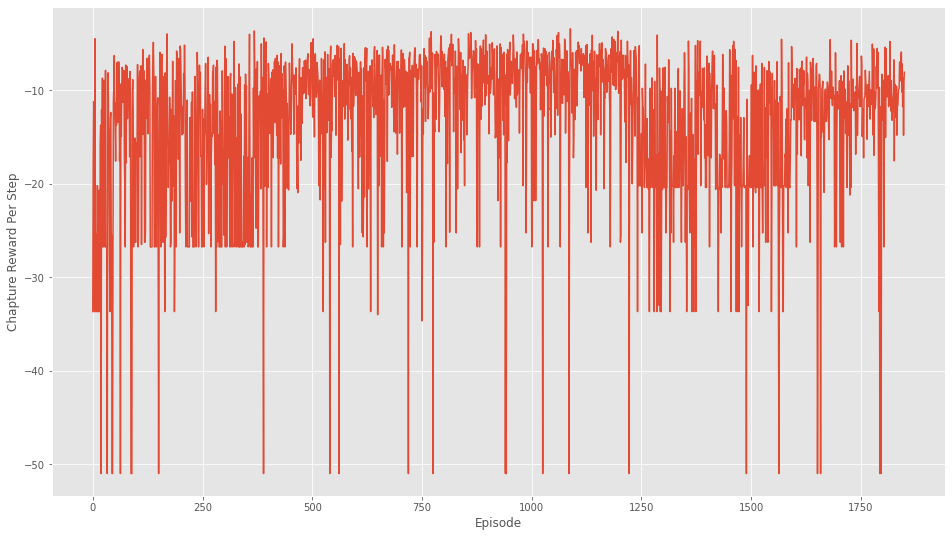

In [24]:
### 平均每一步的吃子奖励
x = range(data_group_sorted3["avg_chapture_reward"].values.shape[0])
y = data_group_sorted3["avg_chapture_reward"].values
plt.figure(figsize = (16, 9))
plt.plot(x, y)
plt.xlabel("Episode")
plt.ylabel("Chapture Reward Per Step")
# plt.show()
plt.savefig(f"./outputs/images/chapture_reward_per_step_1_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

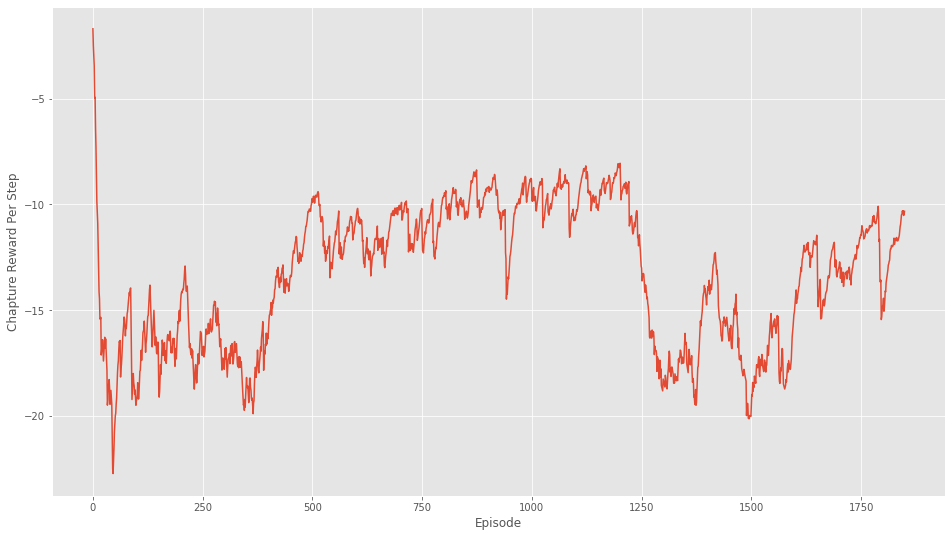

In [25]:
# 做一下平滑1

y = smooth_plot(data_group_sorted3["avg_chapture_reward"].values)
x = range(len(y))

plt.figure(figsize = (16, 9))
plt.xlabel("Episode")
plt.ylabel("Chapture Reward Per Step")
plt.plot(x, y)
plt.savefig(f"./outputs/images/chapture_reward_per_step_2_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

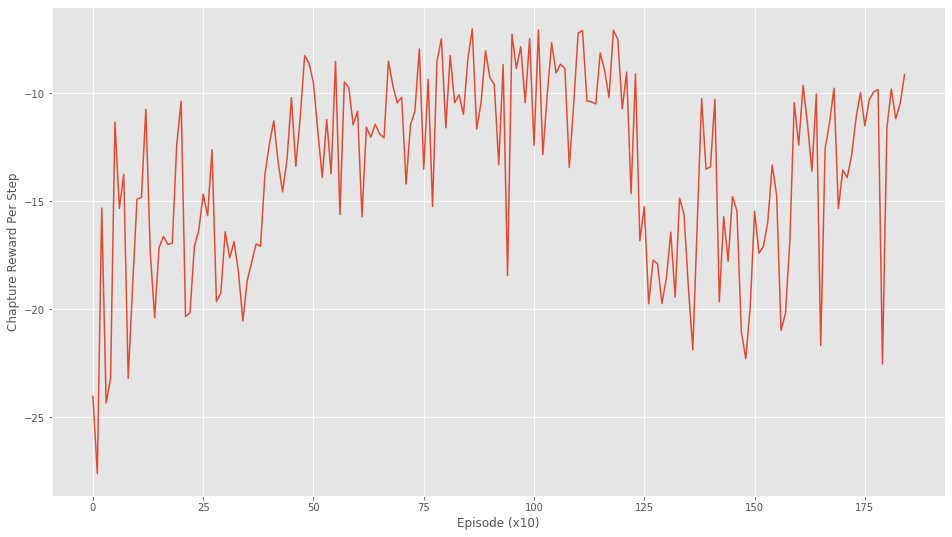

In [26]:
# 做一下平滑2
avg_count_list = []
avg_crewards = data_group_sorted3["avg_chapture_reward"].values.tolist()
for i, val in enumerate(avg_crewards):
    if (i + 1) % 10 == 0:
        avg_val = np.mean(avg_crewards[(i + 1 - 10): (i + 1)])
        avg_count_list.append(avg_val)

plt.figure(figsize = (16, 9))
plt.xlabel("Episode (x10)")
plt.ylabel("Chapture Reward Per Step")
plt.plot(range(len(avg_count_list)), avg_count_list)
plt.savefig(f"./outputs/images/chapture_reward_per_step_3_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

In [27]:
def get_my_chapture_reward(x):
    chesses = x.split(",")
    r = 0
    for c in chesses:
        if c.islower():
            r += hoho_utils.chess_value_equal_to_pawn(c)
    return r
    

In [28]:
data["my_chapture_reward"] = data["chaptures"].apply(get_my_chapture_reward)

In [29]:
data_group = data.groupby("match_id").agg({"my_chapture_reward": sum}).reset_index()
data_group

,match_id,my_chapture_reward
0,0-0,0.00
1,0-1,1.00
2,0-10,0.00
3,0-11,0.00
4,0-12,0.00
...,...,...
1845,9-5,2.71
1846,9-6,0.71
1847,9-7,0.71
1848,9-8,2.71


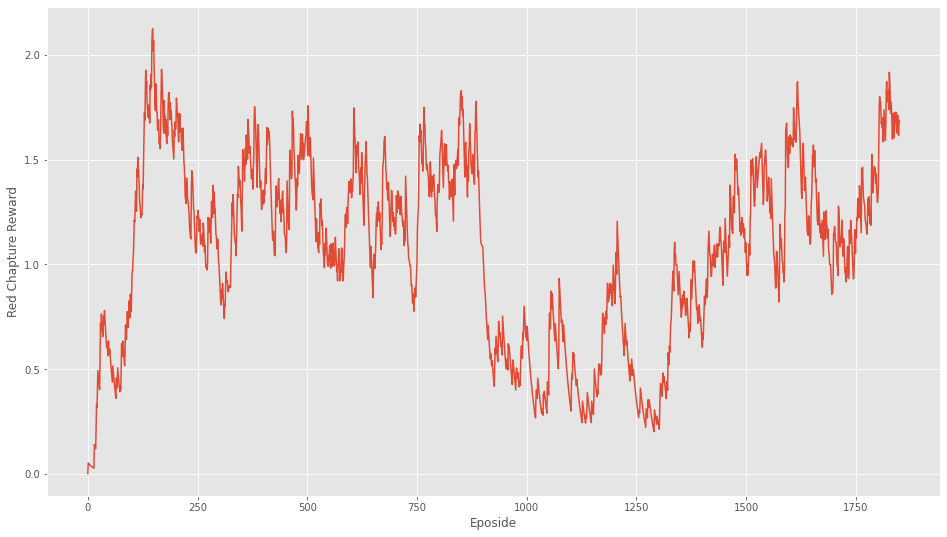

In [30]:
y = smooth_plot(data_group["my_chapture_reward"].values.tolist())
plt.figure(figsize = (16, 9))
plt.plot(range(len(y)), y)
plt.xlabel("Eposide")
plt.ylabel("Red Chapture Reward")
plt.savefig(f"./outputs/images/red_chapture_reward_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

### 分配奖励到指定棋局(Double DQN Learning)

In [40]:
data_demo1 = data[data["match_id"] == "17-48"][["action", "done", "chaptures", "chapture_reward", "raw_reward", "re_reward"]].copy()
data_demo1

,action,done,chaptures,chapture_reward,raw_reward,re_reward
9552,b2f2,False,,0.00,0,-1.0000
9553,f2f6,False,,0.00,0,-1.0000
9554,h2e2,False,,0.00,0,-1.0000
9555,f6f5,False,,0.00,0,-1.0000
9556,f5d5,False,,0.00,0,-1.0000
9557,d5d3,False,,0.00,0,-1.0000
9558,e3e4,False,,0.00,0,-1.0000
9559,e2e1,False,,0.00,0,-1.0000
9560,d3f3,False,,0.00,0,-2.6200
9561,f3e3,False,,0.00,0,-2.8000


In [41]:
data_demo1["raw_reward"] = [-1] * len(data_demo1)
data_demo1

,action,done,chaptures,chapture_reward,raw_reward,re_reward
9552,b2f2,False,,0.00,-1,-1.0000
9553,f2f6,False,,0.00,-1,-1.0000
9554,h2e2,False,,0.00,-1,-1.0000
9555,f6f5,False,,0.00,-1,-1.0000
9556,f5d5,False,,0.00,-1,-1.0000
9557,d5d3,False,,0.00,-1,-1.0000
9558,e3e4,False,,0.00,-1,-1.0000
9559,e2e1,False,,0.00,-1,-1.0000
9560,d3f3,False,,0.00,-1,-2.6200
9561,f3e3,False,,0.00,-1,-2.8000


In [42]:
data_demo2 = data[data["match_id"] == "10-8"][["action", "done", "chaptures", "chapture_reward", "raw_reward", "re_reward"]].copy()
data_demo2["raw_reward"] = [-1] * len(data_demo2)
data_demo2

,action,done,chaptures,chapture_reward,raw_reward,re_reward
4591,b2f2,False,,0.00,-1,-1.0000
4592,i3i4,False,,0.00,-1,-1.0000
4593,f2a2,False,,0.00,-1,-1.0000
4594,a2c2,False,,0.00,-1,-1.0000
4595,i4i5,False,,0.00,-1,-1.0000
4596,i5h5,False,,0.00,-1,-2.6200
4597,h5h6,False,,0.00,-1,-3.3751
4598,h6g6,False,N,-2.00,-1,-5.0590
4599,g6f6,False,A,-0.71,-1,-86.2390
4600,f6f7,False,"R,c",-2.00,-1,-95.0590


### 分配奖励到指定棋局(LSTM-Attention)

In [5]:
file_path = "./outputs/hoho_chess_data_20230905213354.xlsx"
chess_data = pd.read_excel(file_path)

In [6]:
contribution_file = "./outputs/hoho_action_contribution_maxstep15_win-lose-1_20230905213354.xlsx"
contribution_data = pd.read_excel(contribution_file)
contribution_data

,action_type,contribution
0,a0b0,0.065608
1,a0c0,0.061905
2,a0d0,0.000000
3,a0e0,0.000000
4,a0f0,0.000000
...,...,...
2081,e7c9,0.000000
2082,e7g5,0.000000
2083,g5e7,0.000000
2084,g9i7,0.000000


In [67]:
win = -1 # 赢为1，输为-1
hoho_match_data = chess_data[chess_data["match_id"] == "82-7"].copy()  # 随便选一场输的看看
actions_list = hoho_match_data["action"].values
hoho_match_contribution_data = contribution_data[contribution_data["action_type"].isin(actions_list)].copy()
total_contribution = hoho_match_contribution_data["contribution"].sum()
hoho_match_contribution_data["mine"] = hoho_match_contribution_data["contribution"].apply(lambda c: c / total_contribution * (len(hoho_match_contribution_data) * win))
hoho_match_contribution_data["alphago_zero"] = len(hoho_match_contribution_data) * [win]

In [68]:
hoho_match_contribution_data2 = hoho_match_contribution_data.rename(columns = {"action_type": "action"})

In [69]:
hoho_match_contribution_data2

,action,contribution,mine,alphago_zero
0,a0b0,0.065608,-1.088780,-1
8,a0a1,0.066551,-1.104414,-1
20,a1c1,0.065753,-1.091186,-1
204,b0a0,0.063889,-1.060244,-1
212,b0b1,0.055556,-0.921951,-1
223,b0c2,0.066449,-1.102728,-1
226,b1d1,0.044444,-0.737561,-1
253,b2b0,0.062500,-1.037195,-1
693,d1d3,0.044444,-0.737561,-1
904,e0f0,0.065432,-1.085853,-1


In [70]:
match_data_merge = pd.merge(hoho_match_data, hoho_match_contribution_data2, on = "action", how = "left")

In [71]:
match_data_merge

,match_id,round_id,state,action,next_state,done,chaptures,chapture_reward,win,converted,jid,contribution,mine,alphago_zero
0,82-7,16939208404300,RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c...,b0c2,R1BAKABNR/9/1CN4C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5...,0,NaN,0.00,0,0,82-7_16939208404300,0.066449,-1.102728,-1
1,82-7,16939208404301,R1BAKABNR/9/1CN4C1/P1P1P1P1P/9/9/p1p1p1p1p/1c2...,h2h8,R1BAKABNR/9/1CN6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,0,NaN,0.00,0,0,82-7_16939208404301,0.063492,-1.053659,-1
2,82-7,16939208404302,R1BAKABNR/9/1CN6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,b2b0,RCBAKABNR/9/2N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4/...,0,C,-25.41,0,0,82-7_16939208404302,0.062500,-1.037195,-1
3,82-7,16939208404303,RCBAKABNR/9/2N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4/...,c0a2,RC1AKABNR/9/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,0,NaN,0.00,0,0,82-7_16939208404303,0.066516,-1.103845,-1
4,82-7,16939208404304,RC1AKABNR/7r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2...,a0a1,1C1AKABNR/R6r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c...,0,NaN,0.00,0,0,82-7_16939208404304,0.066551,-1.104414,-1
5,82-7,16939208404305,1C1AKABNR/Rc5r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/4...,f0e1,1C1AK1BNR/Rc2A2r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p...,0,NaN,0.00,0,0,82-7_16939208404305,0.066664,-1.106300,-1
6,82-7,16939208404306,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P1P/9/9/p1p1p1p1p/...,i3i4,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,0,NaN,0.00,0,0,82-7_16939208404306,0.066502,-1.103602,-1
7,82-7,16939208404307,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,b0a0,C2AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,0,NaN,0.00,0,0,82-7_16939208404307,0.063889,-1.060244,-1
8,82-7,16939208404308,C2AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,a0b0,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,0,NaN,0.00,0,0,82-7_16939208404308,0.065608,-1.088780,-1
9,82-7,16939208404309,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,b0b1,3AK1BNR/RC2A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,0,NaN,0.00,0,0,82-7_16939208404309,0.055556,-0.921951,-1


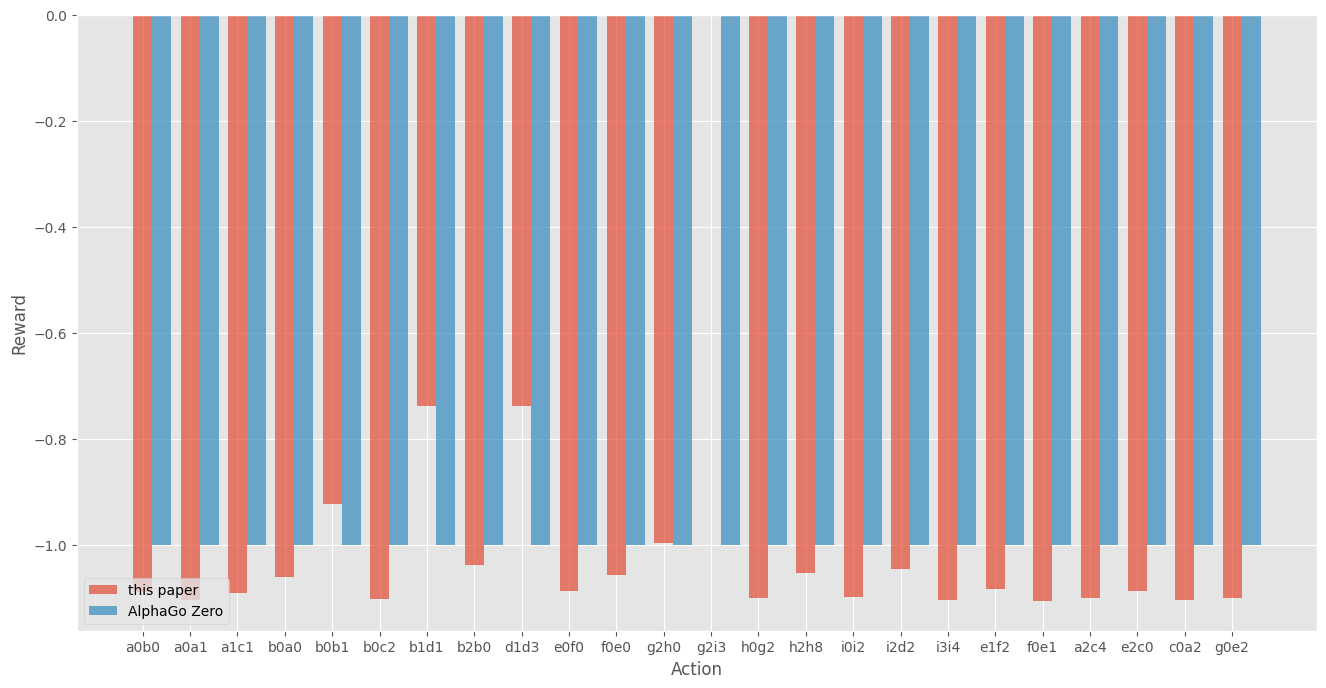

In [72]:
custom_ticks = list(range(len(hoho_match_contribution_data)))
custom_labels = hoho_match_contribution_data2["action"].values.tolist()
plt.figure(figsize = (16, 8))
plt.bar(range(len(hoho_match_contribution_data)), hoho_match_contribution_data["mine"], width=0.4, alpha=0.7, label='this paper' )
plt.bar([i + 0.4 for i in range(len(hoho_match_contribution_data))], hoho_match_contribution_data["alphago_zero"], width=0.4, alpha=0.7, label='AlphaGo Zero'  )
plt.xticks(custom_ticks, custom_labels)
plt.xlabel('Action')
plt.ylabel('Reward')
plt.legend(loc='lower left')
plt.show()

In [36]:
i = 10
i != 0

True

In [37]:
-i

-10

In [38]:
-(-i)

10

In [41]:
for i in reverse(range(3)):
    print(i)

NameError: name 'reverse' is not defined